<a href="https://colab.research.google.com/github/RifaldiAchmad/Face-Mask-Detection-Using-CNN/blob/main/Template_Submission_Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: facemask44k
- **Nama:** Rifaldi Achmad Faisal
- **Email:** rifaldiaf1@gmail.com
- **ID Dicoding:** ripall

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Sering digunakan
import os, shutil, zipfile, random, pathlib
from random import sample
from shutil import copyfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq

In [ ]:
# Pemrosesan data gambar
import cv2
from PIL import Image

import skimage
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Membangun model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d istiakhasan/facemask44k
!unzip facemask44k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Facemask-44k/dataset/without_mask/Aug_547_7241.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_547_7626.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_547_8476.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_547_8892.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_547_9415.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_547_9874.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_1198.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_1261.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_1902.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_3048.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_3235.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_3261.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_4280.png  
  inflating: Facemask-44k/dataset/without_mask/Aug_548_4584.png  
  inflating: Facemask-44k

In [ ]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    num_images = len(image_files)
    print(f"{directory}: {num_images}")
    total_images += num_images

    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        with Image.open(img_path) as img:
            unique_sizes.add(img.size)

    for size in unique_sizes:
        print(f"- {size}")

    print(f"\nTotal: {total_images}")

In [ ]:
# Jumlah gambar beserta resolusinya
print('DATA WITH: ')
print_images_resolution('/content/Facemask-44k/dataset/with_mask')
print('\nDATA WITHOUT: ')
print_images_resolution('/content/Facemask-44k/dataset/without_mask')

DATA WITH: 
/content/Facemask-44k/dataset/with_mask: 22471
- (224, 224)

Total: 22471

DATA WITHOUT: 
/content/Facemask-44k/dataset/without_mask: 22479
- (224, 224)

Total: 22479


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Direktori untuk data train dan test
with_dir = '/content/Facemask-44k/dataset/with_mask'
without_dir = '/content/Facemask-44k/dataset/without_mask'

# Direktori data gabungan
combined_dir = 'dataset/'
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Menyalin file dari with
for category in os.listdir(with_dir):
    category_dir = os.path.join(with_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Menyalin file dari without
for category in os.listdir(without_dir):
    category_dir = os.path.join(without_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

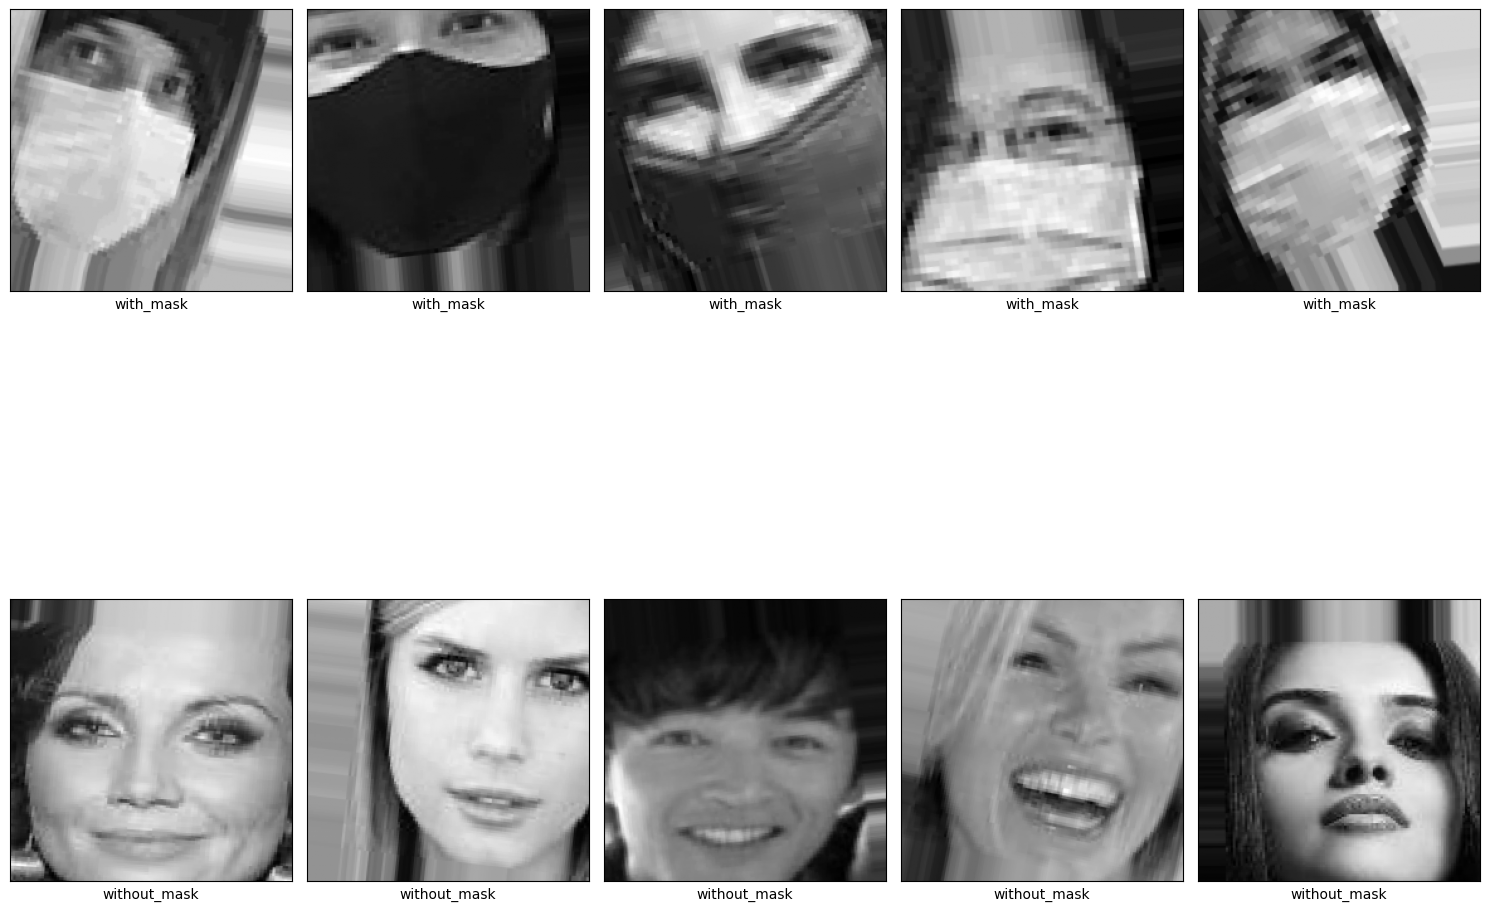

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
cifake_image = {}
path = "/content/Facemask-44k/dataset"

for i in os.listdir(path):
    # path diubah dari path ke path agar sesuai
    cifake_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari dataset
fig, axs = plt.subplots(len(cifake_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(cifake_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Preprocessing

#### Split Dataset

In [ ]:
# Memanggil path yang menampung dataset gambar
mypath = "/content/Facemask-44k/dataset"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan menjadi sebuah dataframe
df = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
df.groupby(['labels']).size()

,0
labels,
with_mask,22471
without_mask,22479


In [ ]:
# Inisialisasi variabel X dan y
X = df['path']
y = df['labels']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_train = pd.DataFrame({'path':X_train, 'labels':y_train, 'set':'train'})
df_test = pd.DataFrame({'path':X_test, 'labels':y_test, 'set':'test'})

df_all = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
dataset_awal = "/content/Facemask-44k/dataset"
dataset_final = "Dataset_Final/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(dataset_awal,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_final,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_final,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_final,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset_Final/train/"
TEST_DIR = "Dataset_Final/test/"

train_without = os.path.join(TRAIN_DIR + 'without_mask')
train_with = os.path.join(TRAIN_DIR + 'with_mask')
test_without = os.path.join(TEST_DIR + 'without_mask')
test_with = os.path.join(TEST_DIR + 'with_mask')

print("Total without mask training set: ",len(os.listdir(train_without)))
print("Total with mask training set: ",len(os.listdir(train_with)))
print("Total without mask test set: ",len(os.listdir(test_without)))
print("Total with mask test set: ",len(os.listdir(test_with)))

Total without mask training set:  18020
Total with mask training set:  17940
Total without mask test set:  4459
Total with mask test set:  4531


In [ ]:
# Normaliasai data menggunakan ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.2,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode='grayscale',
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode='grayscale',
                                              class_mode='binary',
                                              subset='validation',
                                              shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                              batch_size=1,
                                              target_size=(150,150),
                                              color_mode='grayscale',
                                              class_mode='binary',
                                              shuffle=True)

Found 28768 images belonging to 2 classes.
Found 7192 images belonging to 2 classes.
Found 8990 images belonging to 2 classes.


## Modelling

In [ ]:
# Menggunakan convolution, batch normalization, dan max pooling layer sebanyak 3 kali
model = Sequential([
    Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(150,150,1)),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32,(4,4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32,(7,7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Flatten(), # Flatten layer
    Dense(128, activation='relu'), # Dense 1
    Dropout(0.5), # Dropout 1
    Dense(64, activation='relu'), # Dense 2
    Dropout(0.3), # Dropout 2
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
# Hitung class weight
count_with = len(os.listdir(os.path.join(TRAIN_DIR, 'with_mask')))
count_without = len(os.listdir(os.path.join(TRAIN_DIR, 'without_mask')))
total = count_with + count_without
class_weight = {
    0: (1 / count_with) * total / 2.0,
    1: (1 / count_without) * total / 2.0
}

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

## Evaluasi dan Visualisasi

In [ ]:
# Train model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    class_weight=class_weight,
                    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6715 - loss: 0.8015

899/899 ━━━━━━━━━━━━━━━━━━━━ 111s 111ms/step - accuracy: 0.6716 - loss: 0.8012 - val_accuracy: 0.8322 - val_loss: 0.3736 - learning_rate: 0.0010
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 130s 108ms/step - accuracy: 0.9053 - loss: 0.2463 - val_accuracy: 0.7293 - val_loss: 0.5652 - learning_rate: 0.0010
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9372 - loss: 0.1635

899/899 ━━━━━━━━━━━━━━━━━━━━ 99s 111ms/step - accuracy: 0.9372 - loss: 0.1635 - val_accuracy: 0.8920 - val_loss: 0.2398 - learning_rate: 0.0010
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 99s 110ms/step - accuracy: 0.9604 - loss: 0.1092 - val_accuracy: 0.8938 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 102s 113ms/step - accuracy: 0.9676 - loss: 0.0890 - val_accuracy: 0.8895 - val_loss: 0.2465 - learning_rate: 0.0010
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.9751 - loss: 0.0704 - val_accuracy: 0.8865 - val_loss: 0.2624 - learning_rate: 0.0010
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9853 - loss: 0.0418

899/899 ━━━━━━━━━━━━━━━━━━━━ 98s 109ms/step - accuracy: 0.9853 - loss: 0.0417 - val_accuracy: 0.9615 - val_loss: 0.1275 - learning_rate: 2.0000e-04
Epoch 8/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9910 - loss: 0.0228

899/899 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - accuracy: 0.9910 - loss: 0.0228 - val_accuracy: 0.9787 - val_loss: 0.0709 - learning_rate: 2.0000e-04
Epoch 9/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 96s 107ms/step - accuracy: 0.9928 - loss: 0.0199 - val_accuracy: 0.9736 - val_loss: 0.0942 - learning_rate: 2.0000e-04
Epoch 10/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - accuracy: 0.9951 - loss: 0.0141 - val_accuracy: 0.9530 - val_loss: 0.1669 - learning_rate: 2.0000e-04


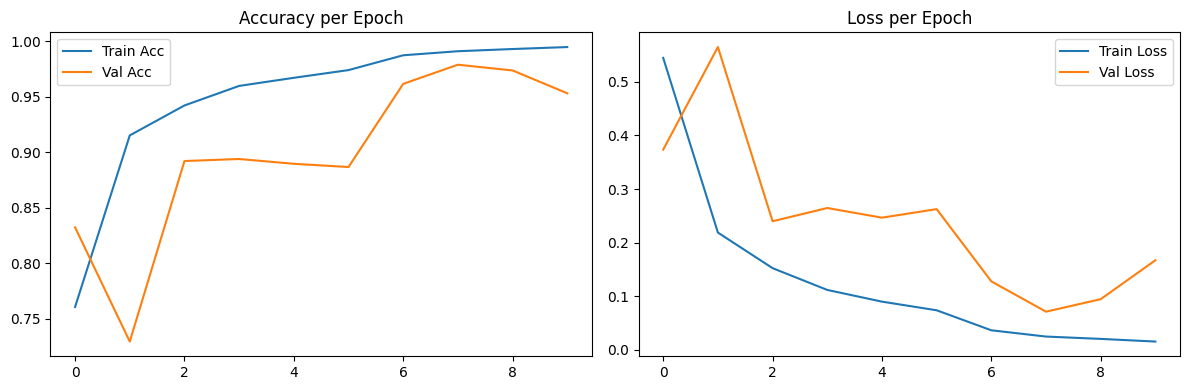

In [ ]:
# Plot akurasi dan loss tiap epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

8990/8990 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9795 - loss: 0.0654
Test Accuracy: 0.9797552824020386
Test Loss: 0.06475349515676498


## Konversi Model

In [ ]:
# Menyimpan model menggunakan saved_model
save_path = 'mymodel/'
# Use the native Keras format for saving the model
model.save('my_model.keras')

In [ ]:
# Menyimpan model dalam bentuk TF-Lite
# Use the native Keras model for TFLite conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmp5oa4rwx7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140250319823760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319824528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319826448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319826832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319818576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319826064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319825872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319827216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319827600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140250319827792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14025031982664

5616964

In [ ]:
# TFJS
# Save the model in the native Keras format before converting to TFJS
model.save("my_model.keras")

# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
# Convert the native Keras model to TFJS
!tensorflowjs_converter --input_format=keras my_model.keras tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.37.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.9.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


2025-09-21 10:18:33.799030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758449913.819010    6899 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758449913.825263    6899 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758449913.841997    6899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758449913.842024    6899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758449913.842032    6899 computation_placer.cc:177] computation placer alr

## Inference Photos

In [ ]:
import requests

image_urls = [
    "https://raw.githubusercontent.com/RifaldiAchmad/Face-Mask-Detection-Using-CNN/main/image/people_1.png",
    "https://raw.githubusercontent.com/RifaldiAchmad/Face-Mask-Detection-Using-CNN/main/image/people_2.jpg"
]

for image_url in image_urls:
    image_filename = image_url.split("/")[-1]
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        with open(image_filename, 'wb') as out_file:
            out_file.write(response.content)
        print(f"Downloaded {image_filename}")
    else:
        print(f"Failed to download image {image_filename}. Status code: {response.status_code}")

Downloaded people_1.png
Downloaded people_2.jpg


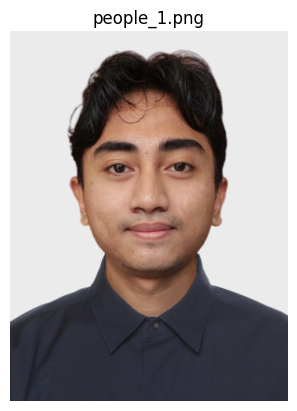

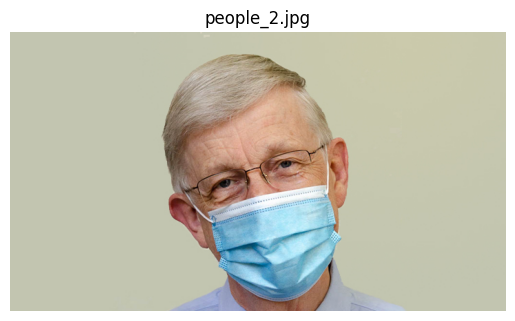

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_filenames = ["people_1.png", "people_2.jpg"]

for image_filename in image_filenames:
    try:
        img = Image.open(image_filename)
        plt.imshow(img)
        plt.title(image_filename)
        plt.axis('off') # Hide axes
        plt.show()
    except FileNotFoundError:
        print(f"Error: {image_filename} not found. Please make sure you have downloaded the images.")

In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Dapatkan detail input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('L').resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)     # (1, 150, 150)
    img_array = np.expand_dims(img_array, axis=-1)    # (1, 150, 150, 1)
    return img_array.astype(np.float32)

In [ ]:
# Load gambar dan preprocess gambar people_1
img_array = preprocess_image('/content/people_1.png')
interpreter.set_tensor(input_details[0]['index'], img_array) # Set input
interpreter.invoke() # Run inference

# Ambil output prediksi
pred = interpreter.get_tensor(output_details[0]['index'])[0][0]

# Tampilkan hasil prediksi
print(f"Predicted class: {'without_mask' if pred > 0.5 else 'with_mask'} | Confidence: {pred:.6f}")

Predicted class: without_mask | Confidence: 1.000000


In [ ]:
# Load gambar dan preprocess gambar people_2
img_array_2 = preprocess_image('/content/people_2.jpg')
interpreter.set_tensor(input_details[0]['index'], img_array_2) # Set input
interpreter.invoke() # Run inference

# Ambil output prediksi
pred_2 = interpreter.get_tensor(output_details[0]['index'])[0][0]

# Tampilkan hasil prediksi
print(f"Predicted class: {'without_mask' if pred_2 > 0.5 else 'with_mask'} | Confidence: {pred:.6f}")

Predicted class: with_mask | Confidence: 1.000000
